# Do logarithmic proximity measures outperform plain ones in graph clustering?

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
import sys
import inspect
from collections import defaultdict
from contextlib import contextmanager
from itertools import combinations, product
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score
# from pylab import *
import math

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sys.path.append('../..')
from py_graphs.graphs.generator import StochasticBlockModel
from py_graphs.measure import *
from py_graphs.measure import H_kernels_plus_RSP_FE, distances, scaler, kernel
from py_graphs.measure.distance import Distance
from py_graphs.cluster.ward import Ward
from py_graphs.colors import d3, d3_category20
from py_graphs.scenario import *
from py_graphs.scorer import copeland

In [5]:
def load_or_calc_and_save(filename):
    def my_decorator(func):
        def wrapped():
            if os.path.exists(filename):
                print('File exist! Skip calculations')
                with open(filename, 'rb') as f:
                    result = pickle.load(f)
            else:
                result = func()
                with open(filename, 'wb') as f:
                    pickle.dump(result, f)
            return result
        return wrapped
    return my_decorator

In [6]:
def ddict2dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)

In [7]:
d3_right_order = []
for i in range(6):
    d3_right_order.extend([d3_category20[2*i + 1], d3_category20[2*i]])
d3_right_order.append(d3_category20[12])

## 4. Reject curves
The optimal values of the family parameters (adjusted to the $[0, 1]$ segment) w.r.t. the ARI in clustering based on Ward’s method for three $G(N,(m)p_{in}, p_{out})$ models are presented in Table 2.

Measure $G(100,(2)0.3,0.05)$, $G(100,(2)0.3,0.1)$, $G(100,(2)0.3,0.15)$

In [8]:
measures_right_order = [
    'pWalk H',
    'Walk H',
    'For H',
    'logFor H',
    'Comm H',
    'logComm H',
    'Heat H',
    'logHeat H',
    'SCT H',
    'SCCT H',
    'RSP K',
    'FE K',    
    'SP-CT H',
    'SP K',
    'CT H'
]
columns = [
    (100, 2, 0.05),
    (100, 2, 0.10),
    (100, 2, 0.15)
]

In [9]:
distances = [
    pWalk,
    Walk,
    For,
    logFor,
    Comm,
    logComm,
    Heat,
    logHeat,
    SCT,
    SCCT,
    RSP,
    FE,
    SPCT,
    SP,
    CT
]

In [10]:
all_measures = H_kernels_plus_RSP_FE + [SP_K, CT_H]

In [11]:
@load_or_calc_and_save('results/4_best_params_5.pkl')
def calc():
    # calc data to find best params
    results = defaultdict(lambda: defaultdict(lambda: 0))
    for column in tqdm(list(product([100], [2], [0.05, 0.1, 0.15]))):
        n_nodes, n_classes, p_out = column
        graphs, info = StochasticBlockModel(n_nodes, n_classes, 0.3, p_out).generate_graphs(100)
        classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 51), progressbar=False)
        for measure_class in tqdm(all_measures, desc=str(column)):
            results[column][measure_class.name] = classic_plot.perform(Ward, measure_class, graphs, n_classes, n_jobs=12)
            
    # find best params
    best_params = defaultdict(lambda: defaultdict(lambda: 0))
    for column, measures in results.items():
        for measure_name, measure_results in measures.items():
            x, y, error = measure_results
            best_idx = np.argmax(y)
            print('{}\t{}\t{:0.2f} ({:0.2f})'.format(column, measure_name.ljust(8, ' '), x[best_idx], y[best_idx]))
            best_params[column][measure_name] = x[best_idx]
    return ddict2dict(best_params)

best_params = calc()
best_params

File exist! Skip calculations


{(100, 2, 0.05): {'CT H': 0.0,
  'Comm H': 0.4,
  'FE K': 0.96,
  'For H': 0.9,
  'Heat H': 0.36,
  'RSP K': 0.98,
  'SCCT H': 0.02,
  'SCT H': 0.44,
  'SP K': 0.0,
  'SP-CT H': 0.04,
  'Walk H': 0.92,
  'logComm H': 0.36,
  'logFor H': 0.62,
  'logHeat H': 0.48,
  'pWalk H': 0.9400000000000001},
 (100, 2, 0.1): {'CT H': 0.0,
  'Comm H': 0.34,
  'FE K': 0.86,
  'For H': 0.98,
  'Heat H': 0.8200000000000001,
  'RSP K': 0.96,
  'SCCT H': 0.58,
  'SCT H': 0.42,
  'SP K': 0.0,
  'SP-CT H': 0.02,
  'Walk H': 0.7000000000000001,
  'logComm H': 0.48,
  'logFor H': 0.54,
  'logHeat H': 0.48,
  'pWalk H': 0.88},
 (100, 2, 0.15): {'CT H': 0.0,
  'Comm H': 0.28,
  'FE K': 0.74,
  'For H': 0.66,
  'Heat H': 0.74,
  'RSP K': 0.9400000000000001,
  'SCCT H': 0.46,
  'SCT H': 0.48,
  'SP K': 0.0,
  'SP-CT H': 0.04,
  'Walk H': 0.7000000000000001,
  'logComm H': 0.78,
  'logFor H': 0.32,
  'logHeat H': 0.34,
  'pWalk H': 0.84}}

In [12]:
def reject_curve(K, y_true):
    y_true_combinations = [0 if a == b else 1 for a, b in combinations(y_true, 2)]
    K_combinations = [K[a, b] for a, b in combinations(range(K.shape[0]), 2)]
    pairs = [(x, y) for x, y in zip(K_combinations, y_true_combinations) if not np.isnan(x)]
    pairs = sorted(pairs, key=lambda x: x[0])
    tpr, fpr = [0], [0]
    for _, class_ in pairs:
        if class_ == 1:
            increment = 1, 0
        else:
            increment = 0, 1
        tpr.append(tpr[-1] + increment[0])
        fpr.append(fpr[-1] + increment[1])
#     print(tpr)
#     raise Exception()
    return np.array(tpr, dtype=np.float) / tpr[-1], np.array(fpr, dtype=np.float) / fpr[-1]

In [13]:
results = defaultdict(lambda: defaultdict(lambda: list()))
for column in tqdm(best_params.keys()): 
    n_nodes, n_classes, p_out = column
    graphs, info = StochasticBlockModel(n_nodes, n_classes, 0.3, p_out).generate_graphs(100)
    for edges, nodes in tqdm(graphs, desc=str(column)):
        single_competition_best = {}
        for kernel_class in distances:
            try:
                param_flat = best_params[column][kernel_class.name + ' H']
                mname = kernel_class.name + ' H'
            except:
                param_flat = best_params[column][kernel_class.name + ' K']
                mname = kernel_class.name + ' K'
            kernel = kernel_class(edges)
            best_param = kernel.scaler.scale(param_flat)
            K = kernel.get_D(best_param)
            tpr, fpr = reject_curve(K, nodes)
            results[column][mname].append((tpr, fpr))

In [14]:
results[column]['CT H']

[(array([0.000e+00, 0.000e+00, 4.000e-04, ..., 9.996e-01, 1.000e+00,
         1.000e+00]),
  array([0.00000000e+00, 4.08163265e-04, 4.08163265e-04, ...,
         9.99591837e-01, 9.99591837e-01, 1.00000000e+00])),
 (array([0.e+00, 0.e+00, 4.e-04, ..., 1.e+00, 1.e+00, 1.e+00]),
  array([0.00000000e+00, 4.08163265e-04, 4.08163265e-04, ...,
         9.99183673e-01, 9.99591837e-01, 1.00000000e+00])),
 (array([0., 0., 0., ..., 1., 1., 1.]),
  array([0.00000000e+00, 4.08163265e-04, 8.16326531e-04, ...,
         9.99183673e-01, 9.99591837e-01, 1.00000000e+00])),
 (array([0.000e+00, 0.000e+00, 4.000e-04, ..., 9.996e-01, 1.000e+00,
         1.000e+00]),
  array([0.00000000e+00, 4.08163265e-04, 4.08163265e-04, ...,
         9.99591837e-01, 9.99591837e-01, 1.00000000e+00])),
 (array([0.e+00, 0.e+00, 4.e-04, ..., 1.e+00, 1.e+00, 1.e+00]),
  array([0.00000000e+00, 4.08163265e-04, 4.08163265e-04, ...,
         9.99183673e-01, 9.99591837e-01, 1.00000000e+00])),
 (array([0., 0., 0., ..., 1., 1., 1.]),


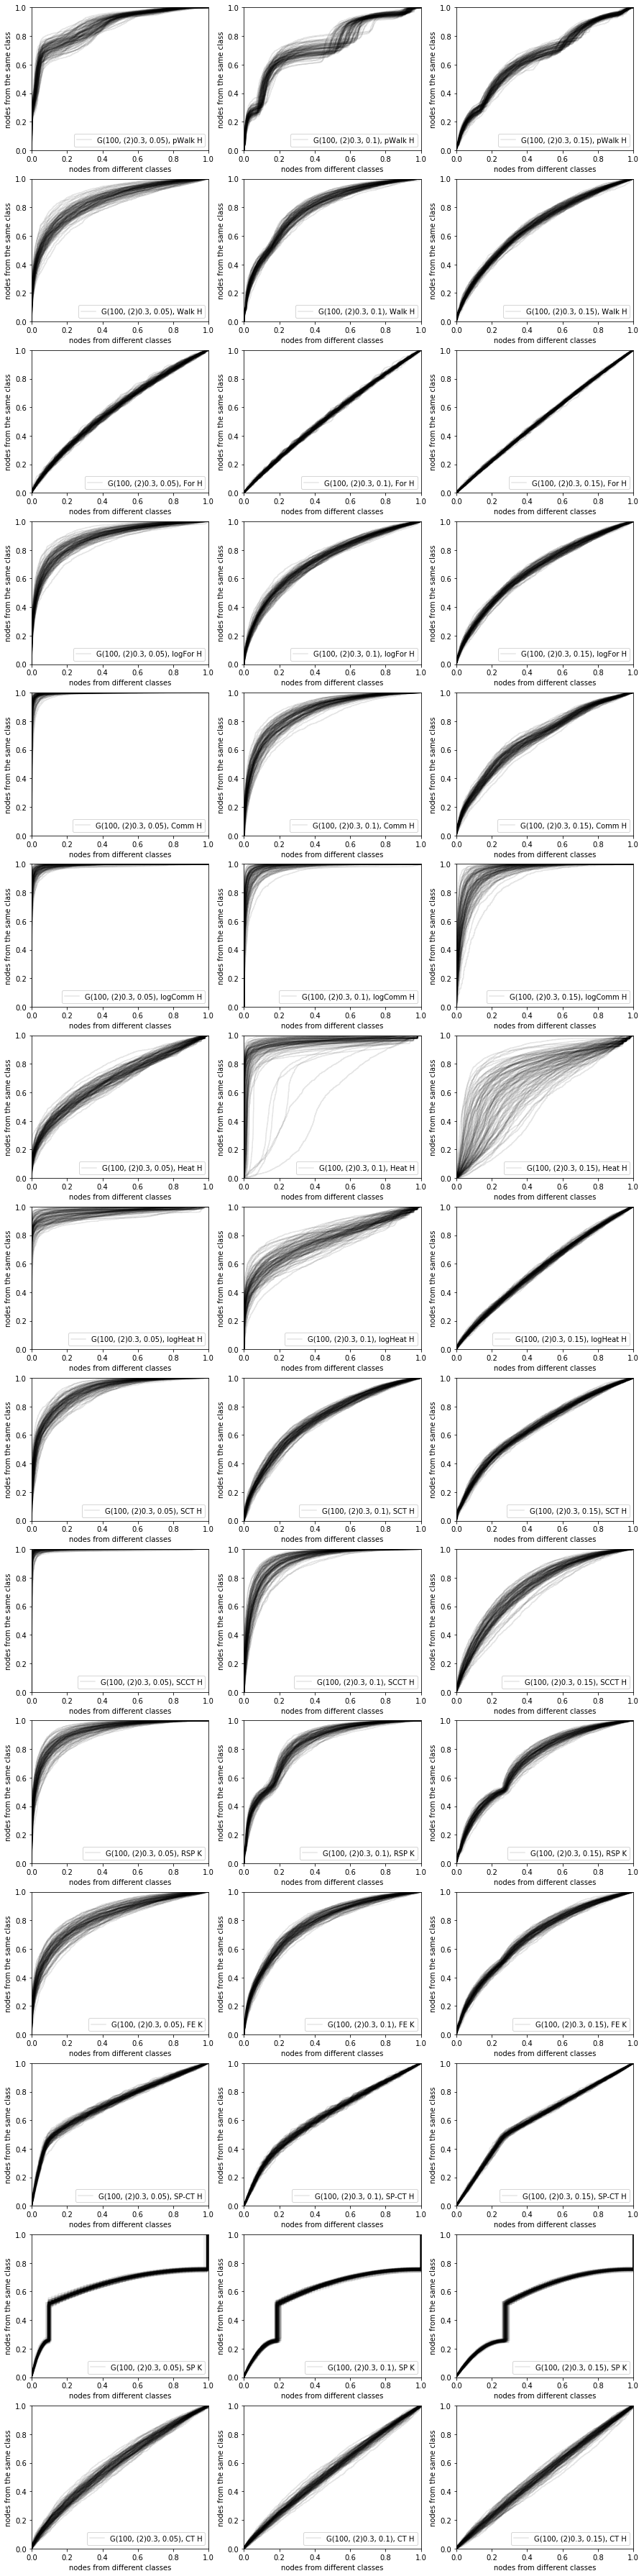

In [15]:
fig, ax = plt.subplots(15, 3, figsize=(15,65))
for column_idx, column in enumerate(columns):
    for measure_name_idx, measure_name in enumerate(measures_right_order):
        axi = ax[measure_name_idx][column_idx]
        for graph_idx, (tpr, fpr) in enumerate(results[column][measure_name]):
            if graph_idx == 1:
                axi.plot(tpr, fpr, label="G({}, ({})0.3, {}), {}".format(*column, measure_name), color='black', alpha=0.1)
            else:
                axi.plot(tpr, fpr, color='black', alpha=0.1)

        axi.set_xlabel("nodes from different classes")
        axi.set_ylabel("nodes from the same class")
        axi.set_xlim(0,1)
        axi.set_ylim(0,1)
        axi.legend(loc=4)
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

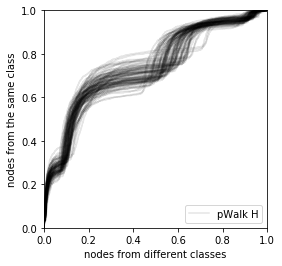

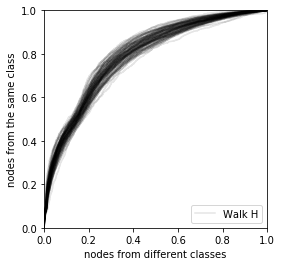

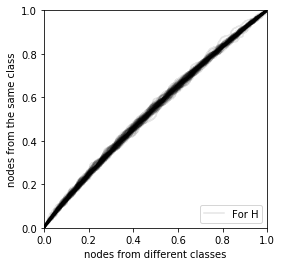

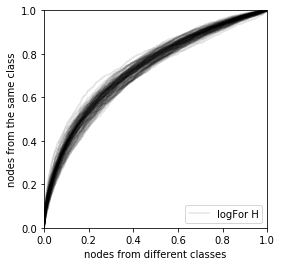

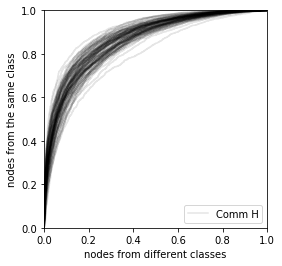

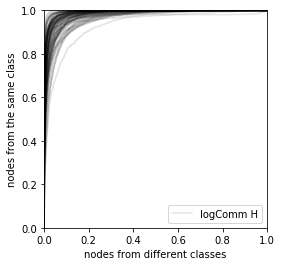

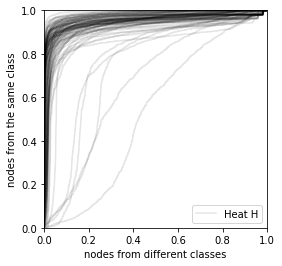

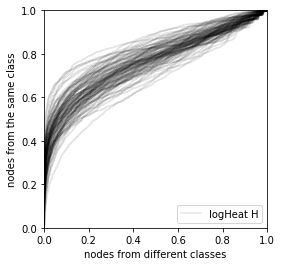

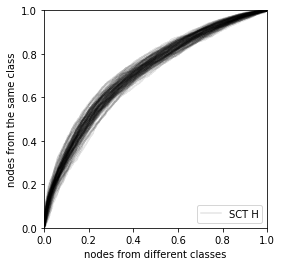

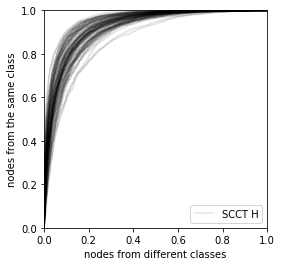

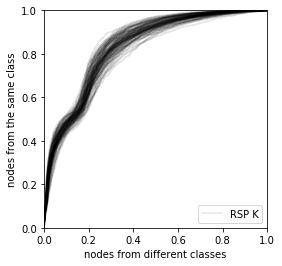

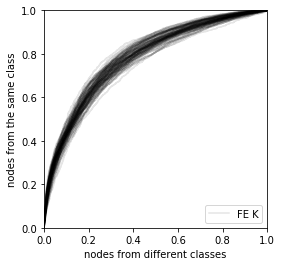

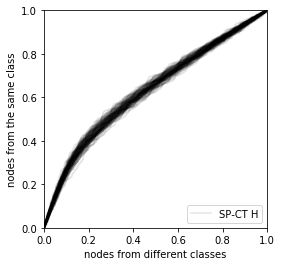

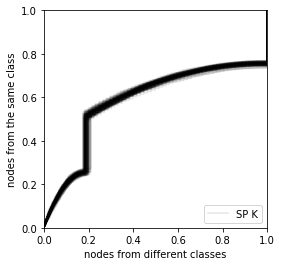

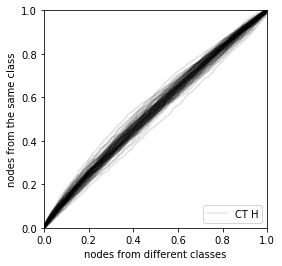

In [16]:
for measure_name_idx, measure_name in enumerate(measures_right_order):
    fig, axi = plt.subplots(1, figsize=(4,4))
    for graph_idx, (tpr, fpr) in enumerate(results[(100, 2, 0.10)][measure_name]):
        if graph_idx == 1:
            axi.plot(tpr, fpr, label=measure_name, color='black', alpha=0.1)
        else:
            axi.plot(tpr, fpr, color='black', alpha=0.1)

    axi.set_xlabel("nodes from different classes")
    axi.set_ylabel("nodes from the same class")
    axi.set_xlim(0,1)
    axi.set_ylim(0,1)
    axi.legend(loc=4)
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

StopIteration: 

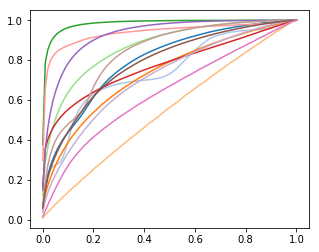

In [17]:
d3c = (x for x in d3_right_order)

fig, axi = plt.subplots(1, figsize=(5, 4))
for measure_name_idx, measure_name in enumerate(measures_right_order):
    tpr_all = defaultdict(list)
    for graph_idx, (tpr, fpr) in enumerate(results[(100, 2, 0.10)][measure_name]):
        tprg = defaultdict(list)
        for ti, fi in zip(fpr, tpr):
            tprg[math.floor(fi * 100)].append(ti)
        for bucket, fis in tprg.items():
            tpr_all[bucket].append(np.mean(fis))
    for bucket, fis in tpr_all.items():
        tpr_all[bucket] = np.mean(fis)
    
    axi.plot(np.array(list(tpr_all.keys()), dtype=np.float) / 100, tpr_all.values(), label=measure_name, color=d3c.__next__())

axi.set_xlabel("nodes from different classes")
axi.set_ylabel("nodes from the same class")

box = axi.get_position()
axi.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axi.set_xlim(0,1)
axi.set_ylim(0,1)
axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

In [ ]:
d3c = (x for x in d3_right_order)

fig, axi = plt.subplots(1, figsize=(5, 4))
for measure_name_idx, measure_name in enumerate(measures_right_order):
    tpr_all = defaultdict(list)
    for graph_idx, (tpr, fpr) in enumerate(results[(100, 2, 0.10)][measure_name]):
        tprg = defaultdict(list)
        for ti, fi in zip(fpr, tpr):
            tprg[math.floor(fi * 100)].append(ti)
        for bucket, fis in tprg.items():
            tpr_all[bucket].append(np.mean(fis))
    for bucket, fis in tpr_all.items():
        tpr_all[bucket] = np.mean(fis)
    
    color = d3c.__next__()
    
    if measure_name not in ['logComm H', 'logFor H', 'logHeat H', 'SCCT H']:
        continue
    
    axi.plot(np.array(list(tpr_all.keys()), dtype=np.float) / 100, tpr_all.values(), label=measure_name, color=color)

axi.set_xlabel("nodes from different classes")
axi.set_ylabel("nodes from the same class")

box = axi.get_position()
axi.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axi.set_xlim(0,1)
axi.set_ylim(0,1)
axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");